In [1]:
# since there might be some random process going on so fix them
seed = 42

# 1. Before applying ML

## Importing and re-formating data

First, we need to import the data we have obtained.  
1. match or battle log data: `{p1 pokemon, p2 pokemon, did p1 win?, URL}`  
2. base stats of each pokemon: `{'Id', 'Name', 'Type(s)', 'TotalBS', 'HP', 'Attack', 'Defense', 'Special Attack', 'Special Defense', 'Speed'}`  

<mark>Q: should pl pokemon be the pokemon which moves first in the match? it is very ambiguous to have pl pokemon just picked by system randomly.</mark>  
A: randonly picked could be better, if p1 always move first then there will be an implicit variable

In [2]:
import json

# 1. match or battle log data
with open('./data/match_ok.json', 'r') as f:
    matches = json.load(f)
# 2. base stats of each pokemon
with open('./data/baseStats.json', 'r') as f:
    baseStats = json.load(f)

# to see how they look like
print(matches[3])
print(baseStats[3])

{'pokemon1': 'arcanine', 'pokemon2': 'sharpedo', 'pokemon1 wins': 1, 'url': 'https://replay.pokemonshowdown.com/destiny-challengecup1v1-550920.log'}
{'Id': 3, 'Name': 'Mega Venusaur', 'Type(s)': ['GRASS', 'POISON'], 'TotalBS': '625', 'HP': '80', 'Attack': '100', 'Defense': '123', 'Special Attack': '122', 'Special Defense': '120', 'Speed': '80'}



Then we need to construct the features and labels from these 2 databases,  
into a format looks like: `{'p1HP' ,'p1ATK' ,'p1DEF' ,'p1SpATK' ,'p1SpDEF' ,'p1SPD' ,'p2HP' ,'p2ATK' ,'p2DEF' ,'p2SpATK' ,'p2SpDEF' ,'p2SPD' ,'p1wins'}`

In [3]:
data = []
nameNotFound = []
N = len(matches)
for idx, match in enumerate(matches):  # from each match
    # extracting battle info of each match
    p1_pokemon = match['pokemon1']
    p2_pokemon = match['pokemon2']
    p1_wins = match['pokemon1 wins']
    # searching for the baseStats given the names of pokemons 
    info = [i for i in baseStats if p1_pokemon == i['Name'].lower() or p2_pokemon == i['Name'].lower()]  # this give [dict{p1 pokemon}, dict{p2 pokemon}]
    # creating new row format
    if len(info) == 2:  # for some reason some of the match contains pokemons that can't be found
        row = {
            'p1HP': int(info[0]['HP']),
            'p1ATK' : int(info[0]['Attack']),
            'p1DEF' : int(info[0]['Defense']),
            'p1SpATK' : int(info[0]['Special Attack']),
            'p1SpDEF' : int(info[0]['Special Defense']),
            'p1SPD' : int(info[0]['Speed']),
            'p2HP' : int(info[1]['HP']),
            'p2ATK' : int(info[1]['Attack']),
            'p2DEF' : int(info[1]['Defense']),
            'p2SpATK' : int(info[1]['Special Attack']),
            'p2SpDEF' : int(info[1]['Special Defense']),
            'p2SPD' : int(info[1]['Speed']),
            'p1wins': p1_wins
            }   
        data.append(row)  # store in a list
    else: 
        case = {'match index': idx, 'pokemon1': p1_pokemon, 'pokemon2': p2_pokemon, 'URL': match['url']}
        nameNotFound.append(case)
    print(f'{idx+1}/{N} done', end="\r")

print(f'\n{len(data)} rows of data can be proceeded, \n{len(nameNotFound)} rows of data went missing')

8895/8895 done
8475 rows of data can be proceeded, 
420 rows of data went missing


Seems like the problem of missing data is due to p1_pokemon is the same as p2_pokemon.  
<mark>Q: are repeated pokemons bad data?</mark>  
A: include them

In [4]:
data = []
nameNotFound = []
N = len(matches)
for idx, match in enumerate(matches):  # from each match
    # extracting battle info of each match
    p1_pokemon = match['pokemon1']
    p2_pokemon = match['pokemon2']
    p1_wins = match['pokemon1 wins']
    # searching for the baseStats given the names of pokemons 
    p1_info = [i for i in baseStats if p1_pokemon == i['Name'].lower()] # this give [dict{p1 pokemon}, dict{p2 pokemon}]
    p2_info = [i for i in baseStats if p2_pokemon == i['Name'].lower()]
    # creating new row format
    if len(info) == 2:  # for some reason some of the match contains pokemons that can't be found
        row = {
            'p1HP': int(p1_info[0]['HP']),
            'p1ATK' : int(p1_info[0]['Attack']),
            'p1DEF' : int(p1_info[0]['Defense']),
            'p1SpATK' : int(p1_info[0]['Special Attack']),
            'p1SpDEF' : int(p1_info[0]['Special Defense']),
            'p1SPD' : int(p1_info[0]['Speed']),
            'p2HP' : int(p2_info[0]['HP']),
            'p2ATK' : int(p2_info[0]['Attack']),
            'p2DEF' : int(p2_info[0]['Defense']),
            'p2SpATK' : int(p2_info[0]['Special Attack']),
            'p2SpDEF' : int(p2_info[0]['Special Defense']),
            'p2SPD' : int(p2_info[0]['Speed']),
            'p1wins': p1_wins
            }   
        data.append(row)  # store in a list
    else: 
        case = {'match index': idx, 'pokemon1': p1_pokemon, 'pokemon2': p2_pokemon, 'URL': match['url']}
        nameNotFound.append(case)
    print(f'{idx+1}/{N} done', end="\r")

print(f'\n{len(data)} rows of data can be proceeded, \n{len(nameNotFound)} rows of data went missing')

8895/8895 done
8895 rows of data can be proceeded, 
0 rows of data went missing


Convert them into pandas DataFrame for better visualistion and statistics summaries.  

In [5]:
import pandas as pd
import numpy as np

df = pd.DataFrame(data)
df.head()

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1wins
0,100,150,120,120,100,90,50,75,75,65,65,50,1
1,85,73,70,73,115,67,80,80,90,110,130,110,1
2,66,41,77,61,87,23,100,120,100,150,120,90,0
3,90,110,80,100,80,95,70,120,40,95,40,95,1
4,115,140,130,55,55,40,85,50,95,120,115,80,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8895 entries, 0 to 8894
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   p1HP     8895 non-null   int64
 1   p1ATK    8895 non-null   int64
 2   p1DEF    8895 non-null   int64
 3   p1SpATK  8895 non-null   int64
 4   p1SpDEF  8895 non-null   int64
 5   p1SPD    8895 non-null   int64
 6   p2HP     8895 non-null   int64
 7   p2ATK    8895 non-null   int64
 8   p2DEF    8895 non-null   int64
 9   p2SpATK  8895 non-null   int64
 10  p2SpDEF  8895 non-null   int64
 11  p2SPD    8895 non-null   int64
 12  p1wins   8895 non-null   int64
dtypes: int64(13)
memory usage: 903.5 KB


done
___

## Feature engineering
- the BaseStats difference between pokemon 1 and pokemon 2
- the BaseStats difference between attack and defence features 

In [7]:
# BaseStats difference between attack and defence features
df['p1ATKp2DEF'] = df['p1ATK'] - df['p2DEF'] # p1 atk to p2 def
df['p2ATKp1DEF'] = df['p2ATK'] - df['p1DEF'] # p2 atk to p1 def
df['p1SpATKp2SpDEF'] = df['p1SpATK'] - df['p2SpDEF'] # p1 spatk to p2 spdef
df['p2SpATKp1SpDEF'] = df['p2SpATK'] - df['p1SpDEF'] # p2 spatk to p1 spdef

# aseStats difference between pokemon 1 and pokemon 2, just speed
df['p1SPDp2SPD'] = df['p1SPD'] - df['p2SPD']

# re-locate 'p1wins'
wins = df['p1wins']
df.drop('p1wins', axis='columns', inplace=True)
df['p1wins'] = wins

df.head()

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1ATKp2DEF,p2ATKp1DEF,p1SpATKp2SpDEF,p2SpATKp1SpDEF,p1SPDp2SPD,p1wins
0,100,150,120,120,100,90,50,75,75,65,65,50,75,-45,55,-35,40,1
1,85,73,70,73,115,67,80,80,90,110,130,110,-17,10,-57,-5,-43,1
2,66,41,77,61,87,23,100,120,100,150,120,90,-59,43,-59,63,-67,0
3,90,110,80,100,80,95,70,120,40,95,40,95,70,40,60,15,0,1
4,115,140,130,55,55,40,85,50,95,120,115,80,45,-80,-60,65,-40,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8895 entries, 0 to 8894
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   p1HP            8895 non-null   int64
 1   p1ATK           8895 non-null   int64
 2   p1DEF           8895 non-null   int64
 3   p1SpATK         8895 non-null   int64
 4   p1SpDEF         8895 non-null   int64
 5   p1SPD           8895 non-null   int64
 6   p2HP            8895 non-null   int64
 7   p2ATK           8895 non-null   int64
 8   p2DEF           8895 non-null   int64
 9   p2SpATK         8895 non-null   int64
 10  p2SpDEF         8895 non-null   int64
 11  p2SPD           8895 non-null   int64
 12  p1ATKp2DEF      8895 non-null   int64
 13  p2ATKp1DEF      8895 non-null   int64
 14  p1SpATKp2SpDEF  8895 non-null   int64
 15  p2SpATKp1SpDEF  8895 non-null   int64
 16  p1SPDp2SPD      8895 non-null   int64
 17  p1wins          8895 non-null   int64
dtypes: int64(18)
memory usage: 1

## Data cleaning 
- just drop nan and drop duplicates

In [9]:
df.drop_duplicates(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6900 entries, 0 to 8893
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   p1HP            6900 non-null   int64
 1   p1ATK           6900 non-null   int64
 2   p1DEF           6900 non-null   int64
 3   p1SpATK         6900 non-null   int64
 4   p1SpDEF         6900 non-null   int64
 5   p1SPD           6900 non-null   int64
 6   p2HP            6900 non-null   int64
 7   p2ATK           6900 non-null   int64
 8   p2DEF           6900 non-null   int64
 9   p2SpATK         6900 non-null   int64
 10  p2SpDEF         6900 non-null   int64
 11  p2SPD           6900 non-null   int64
 12  p1ATKp2DEF      6900 non-null   int64
 13  p2ATKp1DEF      6900 non-null   int64
 14  p1SpATKp2SpDEF  6900 non-null   int64
 15  p2SpATKp1SpDEF  6900 non-null   int64
 16  p1SPDp2SPD      6900 non-null   int64
 17  p1wins          6900 non-null   int64
dtypes: int64(18)
memory usage: 1

done
___

## Train-test-split
1. separate X and y
2. convert to numpy array
3. split

In [10]:
y = df['p1wins'].to_numpy()  # using [[]] is to convert pd.series into pd.DataFrame, so than when converted to numpy it will have the shape of (n, 1) instead of (n, )
X = df.loc[ :, df.columns != 'p1wins' ].to_numpy()

print(f"x shape: {X.shape}\ny shape: {y.shape}")

x shape: (6900, 17)
y shape: (6900,)


In [11]:
from sklearn.model_selection import train_test_split

split_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_size, random_state=seed, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=split_size, random_state=seed, shuffle=True)

print(f'train set: \nX: {X_train.shape}, y: {y_train.shape}\ntest set: \nX: {X_test.shape}, y: {y_test.shape}\nvalidation set: \nX: {X_val.shape}, y: {y_val.shape}')

train set: 
X: (4416, 17), y: (4416,)
test set: 
X: (1104, 17), y: (1104,)
validation set: 
X: (1380, 17), y: (1380,)


done
___

## Normalisation and Standardisation 

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_val_scaled = scaler.fit_transform(X_val)

done
___

## Statistics explanations 


In [13]:
df_train_scaled = pd.DataFrame(X_train_scaled)
df_train_scaled['y'] = pd.DataFrame(y_train)

In [14]:
df_train_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,y
count,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4.416000e+03,4416.000000
mean,1.448117e-16,1.029772e-16,-1.914732e-16,-1.134358e-16,-2.638791e-16,5.712017e-17,-6.556752e-17,-6.596977e-17,9.654113e-18,-4.344351e-17,6.596977e-17,3.740969e-17,3.218038e-17,-4.827057e-18,6.436076e-18,-3.218038e-18,3.378940e-17,0.501359
std,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,1.000113e+00,0.500055
min,-2.813733e+00,-2.911869e+00,-2.816454e+00,-2.555487e+00,-2.618654e+00,-2.648128e+00,-2.768796e+00,-2.869691e+00,-2.785635e+00,-2.538339e+00,-2.603290e+00,-2.617093e+00,-5.580527e+00,-5.459422e+00,-5.781320e+00,-5.846109e+00,-4.328657e+00,0.000000
25%,-5.144469e-01,-6.810822e-01,-5.874139e-01,-8.897554e-01,-6.431554e-01,-6.847433e-01,-5.146108e-01,-7.143360e-01,-5.667126e-01,-8.803588e-01,-6.375484e-01,-6.740730e-01,-5.689624e-01,-6.028857e-01,-6.683832e-01,-6.707018e-01,-6.896545e-01,0.000000
50%,-1.026345e-01,4.064310e-02,-7.302001e-02,1.763125e-01,-5.050584e-02,2.921472e-02,-1.108762e-01,-6.607274e-03,-5.465363e-02,1.807484e-01,-4.782593e-02,3.247966e-02,4.519990e-02,2.221295e-02,3.956184e-02,1.935248e-02,-2.570112e-03,1.000000
75%,4.121310e-01,7.623684e-01,4.413739e-01,7.426611e-01,5.421438e-01,7.431728e-01,3.937921e-01,8.297994e-01,4.574053e-01,7.444616e-01,5.418966e-01,7.390323e-01,6.839287e-01,6.713539e-01,7.212867e-01,6.563257e-01,6.336191e-01,1.000000
max,5.902963e+00,2.861933e+00,4.899454e+00,2.874797e+00,5.678440e+00,4.312963e+00,5.776921e+00,2.792138e+00,4.895249e+00,2.767197e+00,5.652825e+00,4.271796e+00,3.042312e+00,4.061312e+00,2.976223e+00,3.098056e+00,3.560090e+00,1.000000


In [15]:
df_train_scaled.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,y
0,1.000000,0.153319,-0.106631,0.073121,0.212254,-0.040397,0.103823,0.057347,0.045037,0.062080,0.073698,0.045795,0.082402,0.117617,0.008398,-0.092892,-0.061785,-0.005027
1,0.153319,1.000000,0.323387,0.058068,-0.122780,0.150138,0.037478,0.070463,0.072976,0.074284,0.076060,0.047748,0.696332,-0.174060,-0.005024,0.141933,0.072633,0.006403
2,-0.106631,0.323387,1.000000,-0.046598,0.282394,-0.251960,0.036767,0.047780,0.090538,0.083763,0.095096,0.060211,0.177013,-0.665376,-0.100098,-0.122653,-0.222984,0.027346
3,0.073121,0.058068,-0.046598,1.000000,0.312589,0.411294,0.039081,0.049016,0.052864,0.090359,0.061190,0.054255,0.005441,0.069302,0.746238,-0.137657,0.254113,0.021037
4,0.212254,-0.122780,0.282394,0.312589,1.000000,-0.006900,0.073517,0.063341,0.077940,0.085426,0.129909,0.069219,-0.148032,-0.150643,0.159382,-0.603369,-0.054779,0.027106
5,-0.040397,0.150138,-0.251960,0.411294,-0.006900,1.000000,0.028157,0.040087,0.050946,0.008684,0.026064,0.026333,0.075768,0.206604,0.306325,0.011586,0.693890,-0.016783
6,0.103823,0.037478,0.036767,0.039081,0.073517,0.028157,1.000000,0.128469,-0.094217,0.062538,0.224389,-0.051408,0.095868,0.070236,-0.118893,0.000670,0.057102,-0.029977
7,0.057347,0.070463,0.047780,0.049016,0.063341,0.040087,0.128469,1.000000,0.306961,0.028693,-0.147071,0.173738,-0.168134,0.713864,0.136664,-0.019583,-0.096573,-0.036843
8,0.045037,0.072976,0.090538,0.052864,0.077940,0.050946,-0.094217,0.306961,1.000000,-0.039129,0.282771,-0.250597,-0.664991,0.165936,-0.146981,-0.083674,0.216830,-0.016738
9,0.062080,0.074284,0.083763,0.090359,0.085426,0.008684,0.062538,0.028693,-0.039129,1.000000,0.293660,0.410176,0.083787,-0.037281,-0.124733,0.743004,-0.289272,-0.032826


From the correlation matrix, those numbers (coefficient of correlation) are so small,  
but:  
1. feature 0 (`p1HP`)  
2. feature 5 (`p1SPD`)   
3. features 6 to 11 (all `p2`)  
4. feature 13 (`p2ATKp1DEF`), feature 15 (`p2SpATKp1SpDEF`) and feature 16 (`p1SPDp2SPD `)  
shows negative correlations, which is expected. 

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6900 entries, 0 to 8893
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   p1HP            6900 non-null   int64
 1   p1ATK           6900 non-null   int64
 2   p1DEF           6900 non-null   int64
 3   p1SpATK         6900 non-null   int64
 4   p1SpDEF         6900 non-null   int64
 5   p1SPD           6900 non-null   int64
 6   p2HP            6900 non-null   int64
 7   p2ATK           6900 non-null   int64
 8   p2DEF           6900 non-null   int64
 9   p2SpATK         6900 non-null   int64
 10  p2SpDEF         6900 non-null   int64
 11  p2SPD           6900 non-null   int64
 12  p1ATKp2DEF      6900 non-null   int64
 13  p2ATKp1DEF      6900 non-null   int64
 14  p1SpATKp2SpDEF  6900 non-null   int64
 15  p2SpATKp1SpDEF  6900 non-null   int64
 16  p1SPDp2SPD      6900 non-null   int64
 17  p1wins          6900 non-null   int64
dtypes: int64(18)
memory usage: 1

In [21]:
import statsmodels.api as smf

model = smf.Logit(y_train, X_train_scaled).fit_regularized()
model.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6899439071256475
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 4416
Model:                          Logit   Df Residuals:                     4399
Method:                           MLE   Df Model:                           16
Date:                Sun, 13 Jun 2021   Pseudo R-squ.:                0.004616
Time:                        19:37:44   Log-Likelihood:                -3046.8
converged:                       True   LL-Null:                       -3060.9
Covariance Type:            nonrobust   LLR p-value:                   0.02944
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0116      0.034     -0.347      0.729      -0.077       0.054
x2             0.0179   9.01e+05   1.98e-08      1.000   -1.77e+06    1.77e+06
x3             0.0030        nan        nan        nan         nan         nan
x4             0.0275   3.64e+06   7.55e-09      1.000   -7.14e+06    7.14e+06
x5             0.0225        nan        nan        nan         nan         nan
x6            -0.0315      0.016     -1.933      0.053      -0.063       0.000
x7            -0.0372      0.033     -1.121      0.262      -0.102       0.028
x8            -0.0512        nan        nan        nan         nan         nan
x9             0.0093   8.66e+05   1.07e-08      1.000    -1.7e+06     1.7e+06
x10           -0.0338        nan        nan        nan         nan         nan
x11           -0.0283   3.09e+06  -9.16e-09      1.000   -6.05e+06    6.05e+06
x12            0.0050      0.018      0.281      0.779      -0.030       0.040
x13            0.0146    1.2e+06   1.22e-08      1.000   -2.36e+06    2.36e+06
x14           -0.0475        nan        nan        nan         nan         nan
x15            0.0430   4.63e+06   9.29e-09      1.000   -9.07e+06    9.07e+06
x16           -0.0422        nan        nan        nan         nan         nan
x17           -0.0235          0       -inf      0.000      -0.023      -0.023
==============================================================================
"""

Some of the p-values are nan, not sure why (immediate reason is due to invertible matrix, but <mark>why?</mark>).  
<a href="https://stats.stackexchange.com/questions/401751/why-do-i-get-nan-for-p-values-while-using-statsmodels-logit-function">read this to see why some p-values are nan</a>.  

Features `x6` and `x17` are exceptable, which are `p1SPD` and `p2SpATKp1SpDEF`, in terms of p-values. 

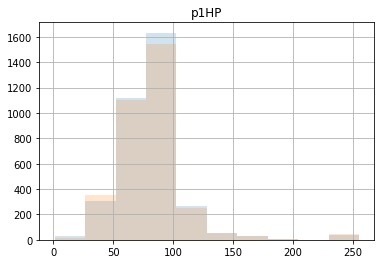

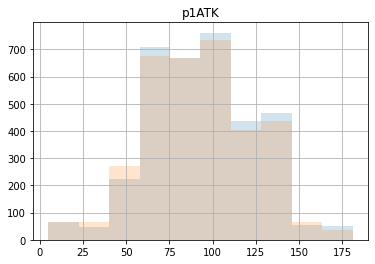

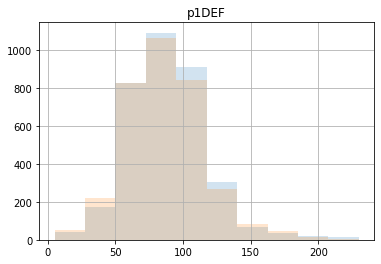

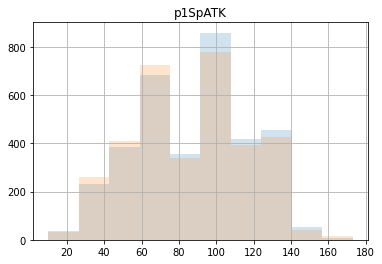

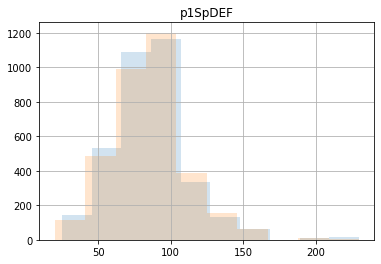

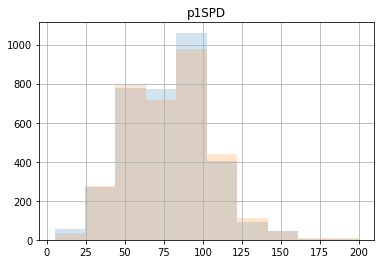

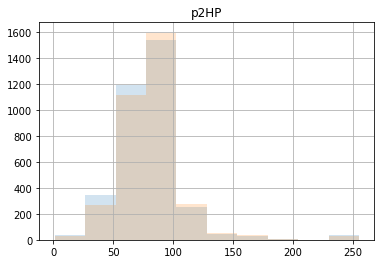

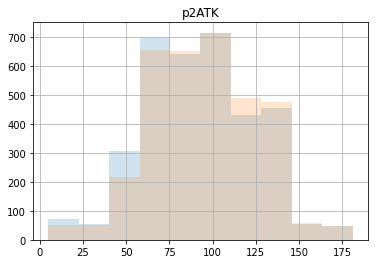

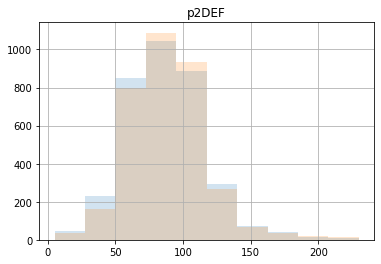

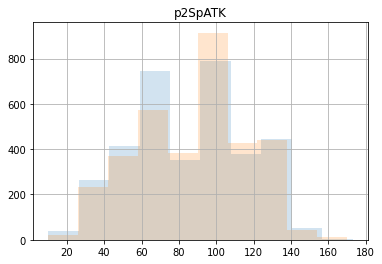

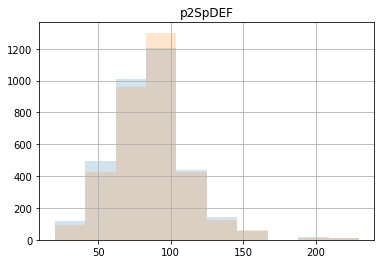

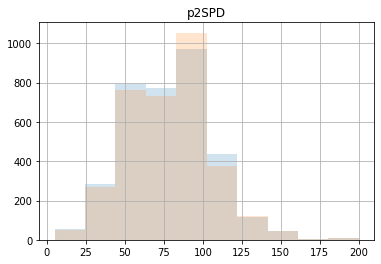

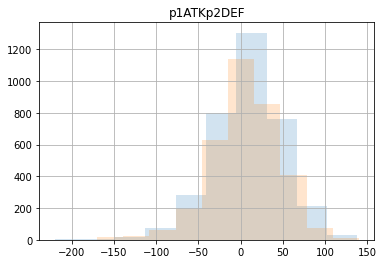

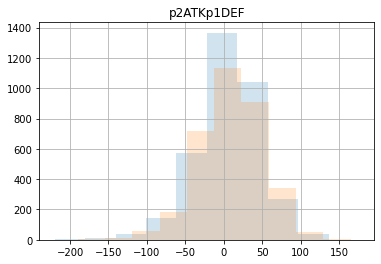

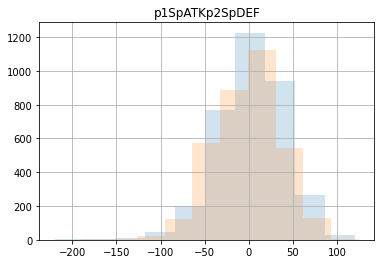

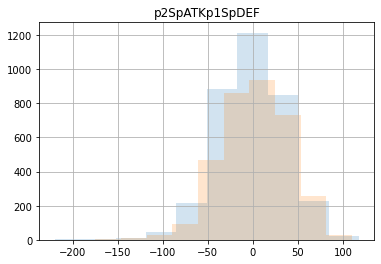

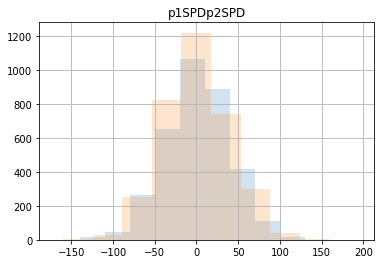

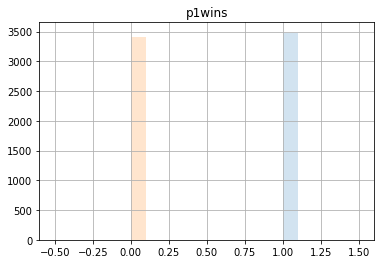

In [18]:
from matplotlib import pyplot as plt

for col in df.columns: 
    df.loc[ df['p1wins'] == 1, col].hist(alpha=0.2)
    df.loc[ df['p1wins'] == 0, col].hist(alpha=0.2)
    plt.title(col)
    plt.show()

The histograms show most of my label distributions for each feature. 
___

## Modelling 
Trying:  
- kNN  
- logistic regression  
- decision tree  

with hyperparameters optimasation and ROC & AUC evaluation, defined as 2 functions for simplification on codes 

## Hyperparameters Optimasation

In [25]:
from sklearn.model_selection import GridSearchCV

def GridSearch_train(learner, grid: dict, X_train, y_train, showAll: bool=False):
    '''
    learner: ML algorithm class \n
    grid: hyperparameters in dictionary with keywords \n
    X_train, y_train: training data \n
    showAll: boolean for showing all details in .cv_results_, default False (showing only combination of hyperparameters and mean_test_score, mean_train_score) \n
    returns results (mean_test_score, mean_train_score) for each combination of hyperparameters
    ''' 
    model = GridSearchCV(estimator=learner, param_grid=grid, return_train_score=True)
    model.fit(X_train, y_train)
    if showAll: 
        return pd.DataFrame( model.cv_results_ )
    return pd.DataFrame( model.cv_results_ )[['params', 'mean_test_score', 'mean_train_score']]

## ROC and AUC Evaluation

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay

def showROC(y_train, y_test, y_pred_train_proba, y_pred_test_proba, title: str='unknown learner'): 
    '''
    y_train: training data (label) \n
    y_test: testing data (label) \n
    y_pred_train_proba: model predicting training data, in .predict_proba() \n
    y_pred_test_proba: model predicting test data, in .predict_proba() \n
    returns AUC and ROC plot of both \n
    only works with label_set = {0, 1} and 1 is True
    '''
    tr_fpr, tr_tpr, tr_threshold = roc_curve(y_train, y_pred_train_proba[:, 1])
    test_fpr, test_tpr, test_threshold = roc_curve(y_test, y_pred_test_proba[:, 1])
    RocCurveDisplay(fpr=tr_fpr, tpr=tr_tpr).plot(name=f'train_{title}: AUC={round(auc(tr_fpr, tr_tpr), 3)}')
    RocCurveDisplay(fpr=test_fpr, tpr=test_tpr).plot(name=f'test_{title}: AUC={round(auc(test_fpr, test_tpr), 3)}')
    pass

### kNN
1. naive kNN (all default hyperparameters)
2. with hyperparameters optimasation

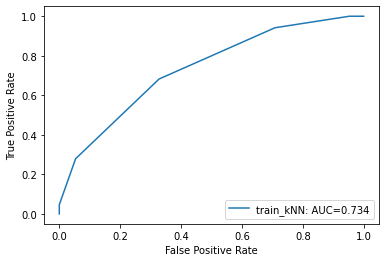

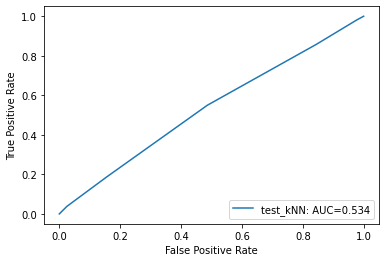

In [27]:
from sklearn.neighbors import KNeighborsClassifier

kNN = KNeighborsClassifier()
kNN.fit(X_train_scaled, y_train)
y_pred_kNN = kNN.predict(X_test_scaled)
y_score_train_kNN = kNN.predict_proba(X_train_scaled)
y_score_test_kNN = kNN.predict_proba(X_test_scaled)

showROC(y_train=y_train, y_test=y_test, y_pred_train_proba=y_score_train_kNN, y_pred_test_proba=y_score_test_kNN, title='kNN')

In [35]:
grid_kNN = {
    'n_neighbors': [1, 65, 501, 3501], 
    'weights': ['uniform', 'distance']
    }
GridSearch_train(learner=KNeighborsClassifier(), grid=grid_kNN, X_train=X_train_scaled, y_train=y_train)

,params,mean_test_score,mean_train_score
0,"{'n_neighbors': 1, 'weights': 'uniform'}",0.461049,0.961447
1,"{'n_neighbors': 1, 'weights': 'distance'}",0.461049,0.961447
2,"{'n_neighbors': 65, 'weights': 'uniform'}",0.511774,0.558707
3,"{'n_neighbors': 65, 'weights': 'distance'}",0.471467,0.961447
4,"{'n_neighbors': 501, 'weights': 'uniform'}",0.519253,0.527683
5,"{'n_neighbors': 501, 'weights': 'distance'}",0.473962,0.961447
6,"{'n_neighbors': 3501, 'weights': 'uniform'}",0.500452,0.502661
7,"{'n_neighbors': 3501, 'weights': 'distance'}",0.475776,0.961447


In [55]:
def fitIt(learner, X_train, y_train, X_test, y_test, name: str): 
    model = learner
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_score_train = model.predict_proba(X_train)
    y_score_test = model.predict_proba(X_test)

    showROC(y_train=y_train, y_test=y_test, y_pred_train_proba=y_score_train, y_pred_test_proba=y_score_test, title=name)


## LogisticRegression
1. naive LogisticRegression (all default hyperparameters)
2. with hyperparameters optimasation

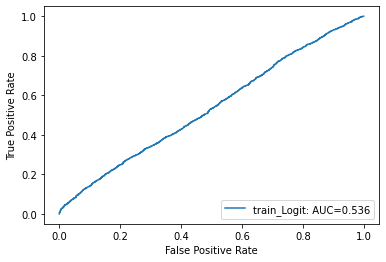

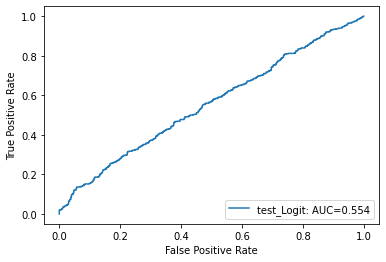

In [36]:
from sklearn.linear_model import LogisticRegression

Logit = LogisticRegression()
Logit.fit(X_train_scaled, y_train)
y_pred_Logit = Logit.predict(X_test_scaled)
y_score_train_Logit = Logit.predict_proba(X_train_scaled)
y_score_test_Logit = Logit.predict_proba(X_test_scaled)

showROC(y_train=y_train, y_test=y_test, y_pred_train_proba=y_score_train_Logit, y_pred_test_proba=y_score_test_Logit, title='Logit')

In [37]:
grid_Logit = {
    'penalty': ['elasticnet'], 
    'solver': ['saga'],
    'l1_ratio': [0.25, 0.5, 0.75]
    }
GridSearch_train(learner=LogisticRegression(), grid=grid_Logit, X_train=X_train_scaled, y_train=y_train)

/Users/jacky/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jacky/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jacky/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/jacky/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


,params,mean_test_score,mean_train_score
0,"{'l1_ratio': 0.25, 'penalty': 'elasticnet', 's...",0.511776,0.518116
1,"{'l1_ratio': 0.5, 'penalty': 'elasticnet', 'so...",0.512682,0.518456
2,"{'l1_ratio': 0.75, 'penalty': 'elasticnet', 's...",0.513134,0.518569


## DecisionTree
1. naive DecisionTree (all default hyperparameters)
2. with hyperparameters optimasation

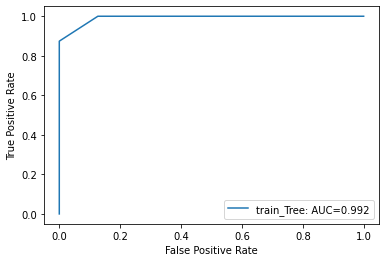

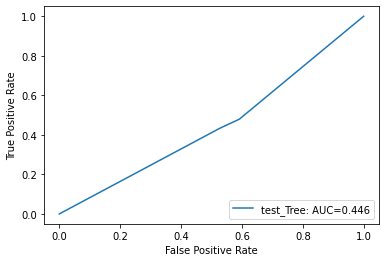

In [38]:
from sklearn.tree import DecisionTreeClassifier

Tree = DecisionTreeClassifier()
Tree.fit(X_train_scaled, y_train)
y_pred_Tree = Tree.predict(X_test_scaled)
y_score_train_Tree = Tree.predict_proba(X_train_scaled)
y_score_test_Tree = Tree.predict_proba(X_test_scaled)

showROC(y_train=y_train, y_test=y_test, y_pred_train_proba=y_score_train_Tree, y_pred_test_proba=y_score_test_Tree, title='Tree')

In [42]:
grid_Tree = {
    'max_depth': [2, 5, 10, 20],  
    'min_samples_leaf': [5, 25, 50, 100, 200, 500],
    'min_samples_split': [200]
    }
GridSearch_train(learner=DecisionTreeClassifier(random_state=seed), grid=grid_Tree, X_train=X_train_scaled, y_train=y_train)

,params,mean_test_score,mean_train_score
0,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.501356,0.534024
1,"{'max_depth': 2, 'min_samples_leaf': 25, 'min_...",0.501356,0.534024
2,"{'max_depth': 2, 'min_samples_leaf': 50, 'min_...",0.501356,0.534024
3,"{'max_depth': 2, 'min_samples_leaf': 100, 'min...",0.502261,0.532156
4,"{'max_depth': 2, 'min_samples_leaf': 200, 'min...",0.509736,0.533118
5,"{'max_depth': 2, 'min_samples_leaf': 500, 'min...",0.516304,0.530740
6,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...",0.517663,0.561764
7,"{'max_depth': 5, 'min_samples_leaf': 25, 'min_...",0.516757,0.562217
8,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.513133,0.566349
9,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.509286,0.563462


In [51]:
X_try_train = X_train_scaled[:, [5, 16]]
X_try_test = X_test_scaled[:, [5, 16]]

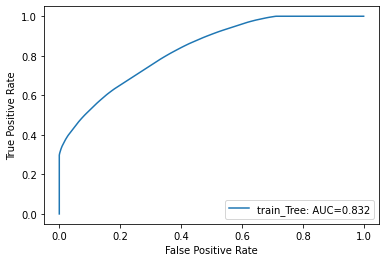

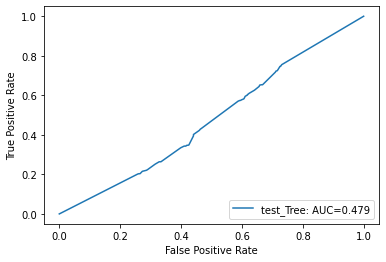

In [52]:
Tree = DecisionTreeClassifier()
Tree.fit(X_try_train, y_train)
y_pred_Tree = Tree.predict(X_try_test)
y_score_train_Tree = Tree.predict_proba(X_try_train)
y_score_test_Tree = Tree.predict_proba(X_try_test)

showROC(y_train=y_train, y_test=y_test, y_pred_train_proba=y_score_train_Tree, y_pred_test_proba=y_score_test_Tree, title='Tree')

In [53]:
grid_Tree = {
    'max_depth': [2, 5, 10, 20],  
    'min_samples_leaf': [5, 25, 50, 100, 200, 500],
    'min_samples_split': [200]
    }
GridSearch_train(learner=DecisionTreeClassifier(random_state=seed), grid=grid_Tree, X_train=X_try_train, y_train=y_train)

,params,mean_test_score,mean_train_score
0,"{'max_depth': 2, 'min_samples_leaf': 5, 'min_s...",0.499322,0.522928
1,"{'max_depth': 2, 'min_samples_leaf': 25, 'min_...",0.497737,0.524739
2,"{'max_depth': 2, 'min_samples_leaf': 50, 'min_...",0.497057,0.525475
3,"{'max_depth': 2, 'min_samples_leaf': 100, 'min...",0.498415,0.526438
4,"{'max_depth': 2, 'min_samples_leaf': 200, 'min...",0.498188,0.526495
5,"{'max_depth': 2, 'min_samples_leaf': 500, 'min...",0.514044,0.526042
6,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...",0.516304,0.546762
7,"{'max_depth': 5, 'min_samples_leaf': 25, 'min_...",0.512001,0.548347
8,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.512681,0.547045
9,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.516981,0.545856


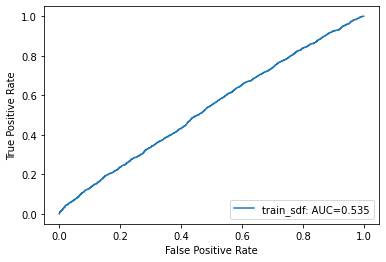

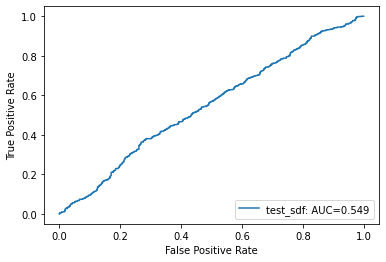

In [62]:
fitIt(learner=LogisticRegression(), X_train=X_train_scaled[:, 13:16], y_train=y_train, X_test=X_val[:, 13:16], y_test=y_val, name='sdf')

working
___

## $f_m$ Optimisation
This is a measure of how good a particular threshold value is:   
$$ 
\begin{align}
    f_m &= \text{TPR} - m \times \text{FPR} \\
    m &= \frac{1 - \text{prevalence}}{\text{prevalence}} \times \frac{\text{cost of negative}}{\text{cost of positive}} \\
    \text{threshold}_{best} &= \mathrm{argmax}\ f_m
\end{align}
$$
Sometimes:  
$$
\begin{align}
    \text{cost of negative} &= \text{cost of False positive} - \text{cost of True negative} \\
    \text{cost of positive} &= \text{cost of False negative} - \text{cost of True positive} \\
    m &= \frac{1 - \text{prevalence}}{\text{prevalence}} \times \frac{C_{FP}-C_{TN}}{C_{FN}-C_{TP}}
\end{align}
$$
$\text{cost of negative}$ and $\text{cost of positive}$ are pre-determined values and usually we guess them based on the consequences for getting negative or positive results.  
So, within a set of values for threshold, the higher $f_m$ value, the better threshold. 

In [59]:
def fmOptimisation(prevalence: float, threshold: np.ndarray, FPR: np.ndarray, TPR: np.ndarray, cost_negative: float=2, cost_positive:float=1): 
    '''
    '''
    m = (1-prevalence)/prevalence * cost_negative/cost_positive
    fm = TPR - m*FPR
    best_threshold = threshold[ np.argmax(fm) ]
    return best_threshold

In [60]:
prevalence_Tree = np.sum( y_pred_Tree==1 )/len(y_pred_Tree)
fpr_Tree, tpr_Tree, threshold_Tree = roc_curve(y_test, y_score_test_Tree[:, 1])

fmOptimisation(prevalence=prevalence_Tree, threshold=threshold_Tree, FPR=fpr_Tree, TPR=tpr_Tree)

2.0